# Pre-entrega N° 3

 Objetivo:
 - Predecir características glaciares no medidas.
 - Enterder los controles ambientales para su distribución.

En esta pre-entrega se busca utilizan métodos supervisados de ML para predecir algunos de las características encontradas comunmente en el estudio de los glaciares, como la clasificación primaria y altura mínima a la que se encuentran las geoformas. Este procedimiento será de utilidad para predecir alturas mínimas en zonas no muestreadas, basándose en datos topográficos o, podría aplicarse también, teniendo en cuenta otras variables como meteorología, geología, etc.

Debido a la naturaleza de los datos decidimos aplicar dos métodos de aprendizaje no supervisado: Random Forest y KNN.

Random Forest al manejar datos no lineales es ideal para esta zona de estudio, ya que los Andes Desérticos presentan una variabilidad geográfica compleja. Permite identificar factores que influyen en las alturas mínimas y trabajar con datos escasos o dispersos, como en este caso.

Por otro lado, El KNN aunque puede no funcionar bien en zonas con tanta variabilidad como son los Andes. Es útil cuando los datos no siguen una distribución normal, como es en la mayoría de los ambientes naturales.

Las alturas mínimas en zonas glaciares están asociadas a áreas de acumulación de agua. Contribuyendo al desarrolla de vegas (oasis) que son sustento para la flora y fauna a esas alturas. También podría monitorear áreas propensas a inundaciones  o deslizamientos repentinos producto del derretimiento del hielo.

En regiones remotas, la falta de datos puede afectar la presición. Aunque tenemos una cantidad considerable, al tener tanta variabilidad altitudinal podría afectar los resultados obtenidos.

Preguntas tenidas en cuenta:

¿Qué variable influye más para la predicción de la altura mínima total en los glaciares?

##1. Importación de librerías
Importamos librerias a utilizar

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

In [57]:
import os

##2. Carga del dataset

Leemos los datos (CSV limpio, creado en pre entrega 2)

In [58]:
# Lectura de datos

df= pd.read_csv ('https://raw.githubusercontent.com/ErikaPellegrini/Proyecto_final/refs/heads/Segunda-pre-entrega(14.05.2025)/Glaciares_final.csv')

Visualización del df

In [59]:
df.head()

,Provincia,Cuenca,Subcuenca,Codigo_cuenca,ID_local,Tipo_geoforma,Clas_prima,Origen_GE,Act_GE,Forma_GE,...,H_min_total,Pendiente,Orientacion,H_max_parcial,H_media_parcial,H_min_parcial,Img_ba_F,Img_ba_S,Img_ap_S_Bing/Google Earth,Img_ap_S_Desconocido
0,0,10,0,14,1306,4,7,-1.0,-1.0,-1.0,...,5261.880000,22.304160,5,5328.640000,5295.240000,5263.520000,5,0,False,True
1,0,10,0,14,1312,4,7,-1.0,-1.0,-1.0,...,5261.880000,22.304160,5,5328.640000,5295.240000,5263.520000,5,0,False,True
2,2,7,17,5,1829,4,7,-1.0,-1.0,-1.0,...,5608.068441,15.612494,6,5688.110266,5648.494297,5611.326996,8,0,False,True
3,2,7,17,5,1876,4,7,-1.0,-1.0,-1.0,...,5608.068441,15.612494,6,5688.110266,5648.494297,5611.326996,8,0,False,True
4,2,7,17,5,1834,4,7,-1.0,-1.0,-1.0,...,5608.068441,15.612494,6,5688.110266,5648.494297,5611.326996,8,0,False,True


##3. Definición de nuevas variables

In [60]:
# Categorizamos el feature Área en 3 clases, de acuerdo al tamaño de la misma
df_copia = df.copy()

# Calculo de cuantiles

q1 = df['H_min_total'].quantile(0.25) #Área menor a q1 -> A_pequeño

q3 = df_copia['H_min_total'].quantile(0.75) #Área mayor a q3 -> A_grande

# Categoorizamos en 3 clases
df_copia['H_min_total_cat'] = pd.cut(df['H_min_total'], bins=[df['H_min_total'].min(), q1, q3, df['H_min_total'].max()], labels=['H_min_bajo', 'H_min_medio', 'H_min_alto'],
    include_lowest=True, duplicates='drop')


## 3. Preparación de los datos

Estandarizamos los datos para asegurar que todas las características con las que se trabaje en machine learning contribuyan de forma justa al modelo. Solo se pueden estandarizar features con datos numéricos datos numéricos.

In [61]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Identificamos que columnas son numéricas
columnas_numericas = df_copia.select_dtypes(include=['int64', 'float64']).columns

# Escalarmos solo las numéricas (Evita escalar las con valores booleanos o categóricos

df_escalado = df_copia.copy()
df_escalado[columnas_numericas] = scaler.fit_transform(df_copia[columnas_numericas])

print(df_escalado.head())

   Provincia  Cuenca  Subcuenca  Codigo_cuenca  ID_local  Tipo_geoforma  \
0        0.0     1.0   0.000000       0.608696  0.416189            1.0   
1        0.0     1.0   0.000000       0.608696  0.418101            1.0   
2        0.4     0.7   0.653846       0.217391  0.582855            1.0   
3        0.4     0.7   0.653846       0.217391  0.597833            1.0   
4        0.4     0.7   0.653846       0.217391  0.584449            1.0   

   Clas_prima  Origen_GE  Act_GE  Forma_GE  ...  Pendiente  Orientacion  \
0    0.714286        0.0     0.0       0.0  ...   0.552624     0.714286   
1    0.714286        0.0     0.0       0.0  ...   0.552624     0.714286   
2    0.714286        0.0     0.0       0.0  ...   0.374744     0.857143   
3    0.714286        0.0     0.0       0.0  ...   0.374744     0.857143   
4    0.714286        0.0     0.0       0.0  ...   0.374744     0.857143   

   H_max_parcial  H_media_parcial  H_min_parcial  Img_ba_F  Img_ba_S  \
0       0.562097         0

Chequeamos que no hayan features con valores nulos.

In [62]:
df_escalado.isnull().sum()

,0
Provincia,0
Cuenca,0
Subcuenca,0
Codigo_cuenca,0
ID_local,0
Tipo_geoforma,0
Clas_prima,0
Origen_GE,0
Act_GE,0
Forma_GE,0


##4. Selección de variables X (features) e Y (target)

###4.1 Evaluación del desbalance de datos

Nuestro objetivo era aplicar un modelo supervisado de machine learning utilizando la variable Clas_prima como feature, ya que consideramos que esta clasificación podría brindar información valiosa para predecir el tipo de glaciar a partir de sus características morfológicas.

Sin embargo, este feature presenta un gran desbalance en la distribución de clases (como se muestra a continuación), por lo cual no fue posible aplicar un modelo supervisado de manera válida, ya que el mismo no seria capaz de clasificar de forma correcta las clases minoritarias.

/tmp/ipython-input-63-1457747636.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_copia['Clas_prima'], palette='Set2')


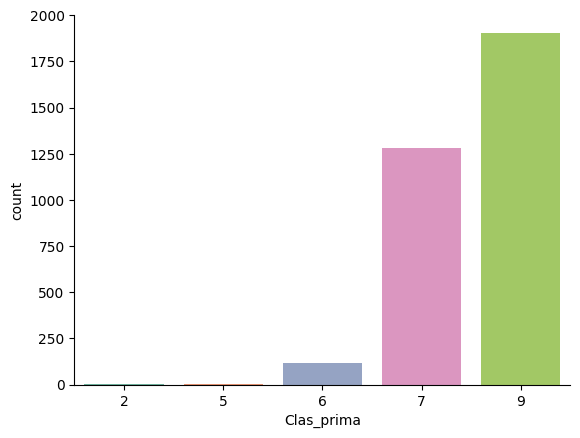

In [63]:
sns.countplot(x=df_copia['Clas_prima'], palette='Set2')
sns.despine()

In [64]:
Conteo_clases = df_copia['Clas_prima'].value_counts()

# Total de muestras
total_muestras = Conteo_clases.sum()

# Clase mayoritaria y minoritaria
Conteo_clase_mayoritaria = Conteo_clases.max()
Conteo_clase_minoritaria = Conteo_clases.min()

# Ratio de desbalance
ratio_desbalance = Conteo_clase_mayoritaria / Conteo_clase_minoritaria

print(f"Ratio de desbalance (mayoritaria / minoritaria): {ratio_desbalance:.2f}")

Ratio de desbalance (mayoritaria / minoritaria): 635.33


Es por esto que optamos por trabajar con el feature H_min_total, que representa la altura minima de cada glaciar del conjunto analizado.

Utilizando la variable **H_min_total** se podrá obtener información valiosa para predecir la altura mínima en la que se encuentra el límite entre hielo a temperaturas menores a 0 (agua en estado sólido) y mayor o igual a cero (agua en estado líquido). Este límite se llama isoterma cero (isoterma: línea imaginaria que une puntos de igual temperatura). Al aplicar este modelo, será posible determinar a partir de qué altura se originan los glaciares en las distintas provincias de nuestro país, incluso en aquellas donde no se cuenta con datos recolectados previamente.


/tmp/ipython-input-65-3754867713.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_copia['H_min_total_cat'], palette='Set2')


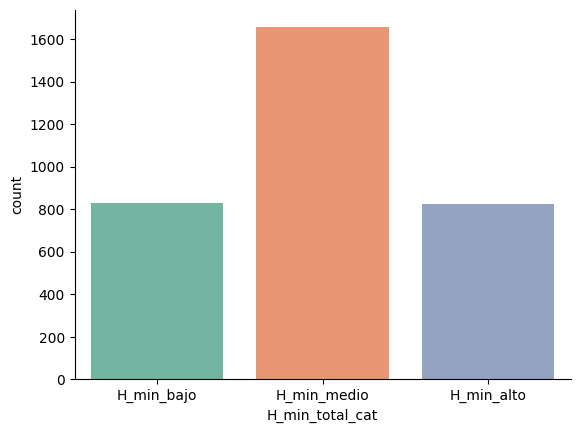

In [65]:
sns.countplot(x=df_copia['H_min_total_cat'], palette='Set2')
sns.despine()

In [66]:
Conteo_clases = df_copia['H_min_total_cat'].value_counts()

# Total de muestras
total_muestras = Conteo_clases.sum()

# Clase mayoritaria y minoritaria
Conteo_clase_mayoritaria = Conteo_clases.max()
Conteo_clase_minoritaria = Conteo_clases.min()

# Ratio de desbalance
ratio_desbalance = Conteo_clase_mayoritaria / Conteo_clase_minoritaria

print(f"Ratio de desbalance (mayoritaria / minoritaria): {ratio_desbalance:.2f}")

Ratio de desbalance (mayoritaria / minoritaria): 2.00


La clase mayoritaria tiene el doble de muestras que la clase minoritaria, pero se mantendria como una razon (o ratio) tolerable (en bibliografía mencionan que ratios desde los 5:1 comienzan a tener efectos considerables de error). (fuente https://storm.cis.fordham.edu/gweiss/papers/foundations-imbalanced-13.pdf)

##Prueba clasificación feature "H_min_total_et"



En primer lugar, probamos el modelo utilizando todos los features:

En primer lugar, evaluamos la correlación entre features, para evitar incluir en el modelo de ML aquellOs que presenten una alta correlación entre sÍ (pueden generar redundancia y afectar, de forma negativa, al modelo)

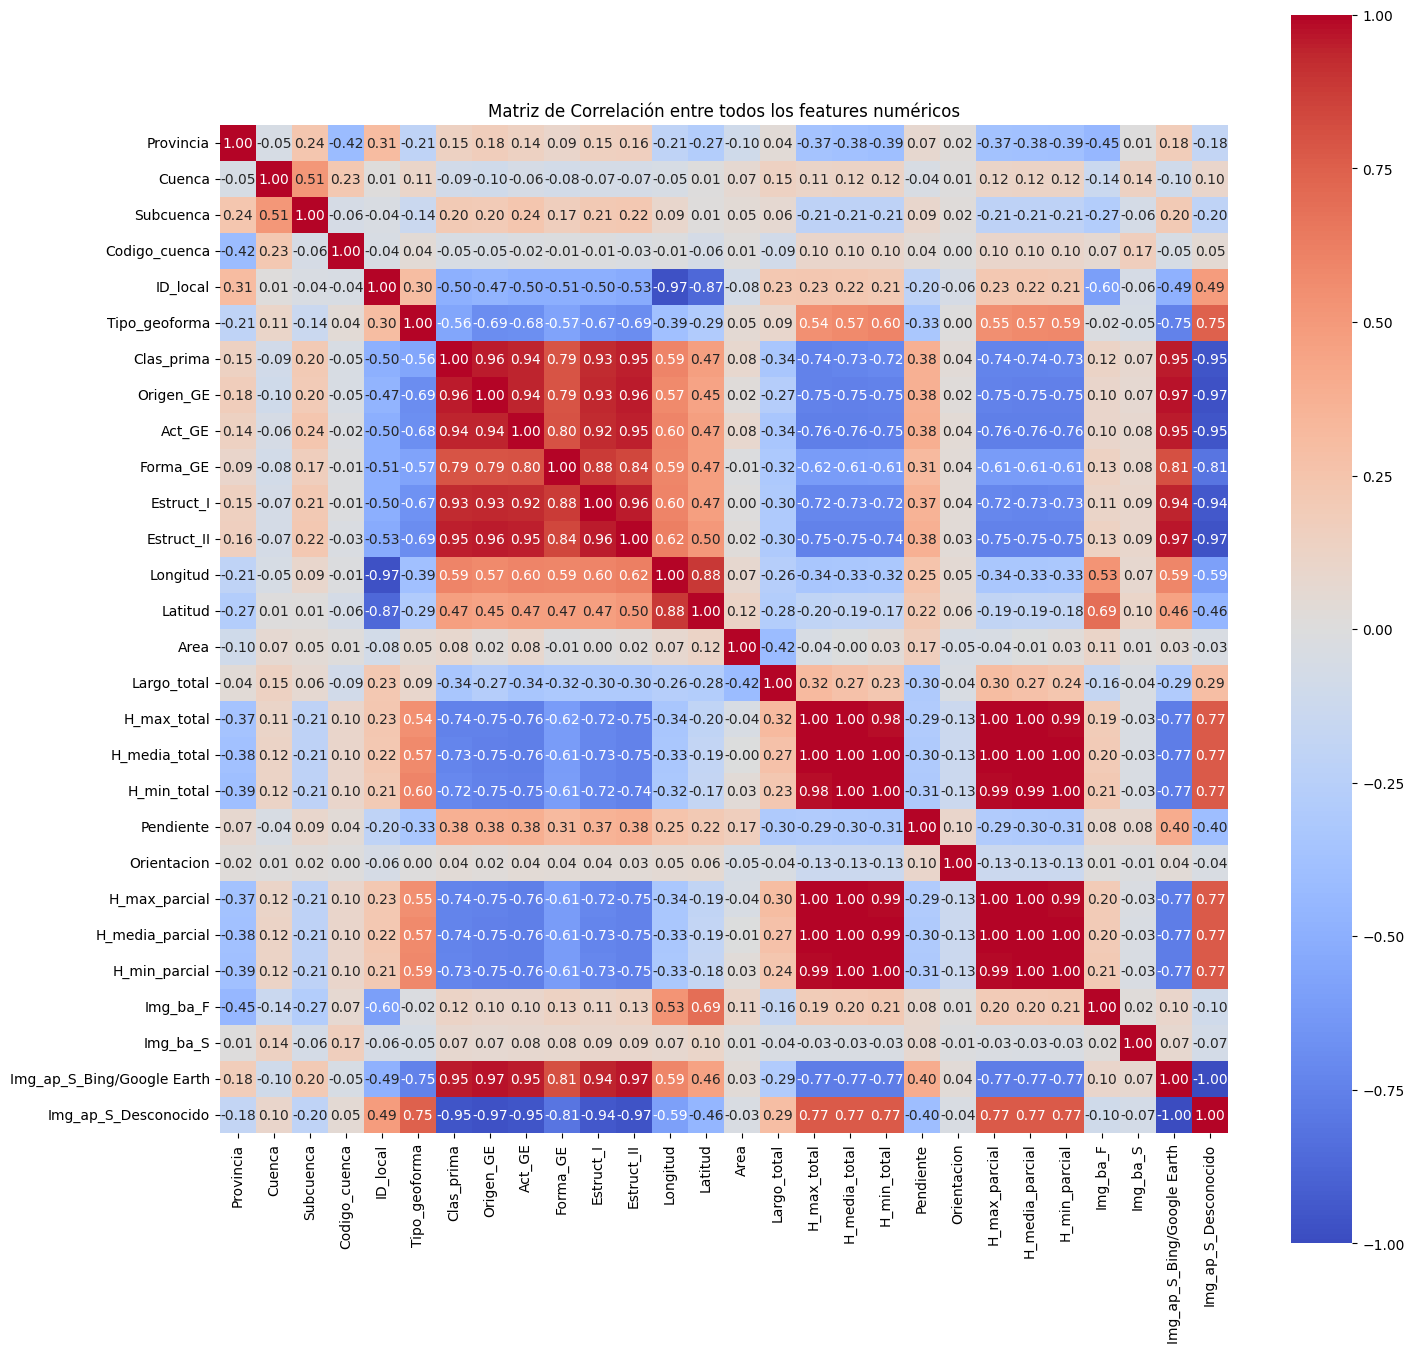

In [67]:
# Visualizamos correlación entre features

correlation_matrix = df_escalado.corr(numeric_only=True)

plt.figure(figsize=(15, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Matriz de Correlación entre todos los features numéricos') # Update title
plt.tight_layout()
plt.show()

In [68]:
# Eliminamos las variables que no queremos incluir en el modelo y las guardamos en x.
x = df_escalado.drop(['H_min_total_cat','Act_GE','Origen_GE','Img_ap_S_Bing/Google Earth','H_max_parcial', 'H_max_total','H_media_total','H_media_parcial','H_min_parcial','H_min_total', 'Img_ap_S_Desconocido', 'Img_ba_S', 'Img_ba_F', 'H_media_total','Tipo_geoforma'] , axis=1)

In [69]:
# Visualizamos
x.head()

,Provincia,Cuenca,Subcuenca,Codigo_cuenca,ID_local,Clas_prima,Forma_GE,Estruct_I,Estruct_II,Longitud,Latitud,Area,Largo_total,Pendiente,Orientacion
0,0.0,1.0,0.000000,0.608696,0.416189,0.714286,0.0,0.0,0.0,0.594118,0.480549,0.5,0.133574,0.552624,0.714286
1,0.0,1.0,0.000000,0.608696,0.418101,0.714286,0.0,0.0,0.0,0.594118,0.480549,0.5,0.133574,0.552624,0.714286
2,0.4,0.7,0.653846,0.217391,0.582855,0.714286,0.0,0.0,0.0,0.226406,0.257116,0.0,0.520014,0.374744,0.857143
3,0.4,0.7,0.653846,0.217391,0.597833,0.714286,0.0,0.0,0.0,0.226406,0.257116,0.0,0.520014,0.374744,0.857143
4,0.4,0.7,0.653846,0.217391,0.584449,0.714286,0.0,0.0,0.0,0.226406,0.257116,0.0,0.520014,0.374744,0.857143


In [70]:
lista_atributos = x.columns

In [71]:
# Seleccionamos las etiquetas y las guardamos en y
y = df_escalado['H_min_total_cat']

In [72]:
#x son los nuevos atributos
# y la variable a predecir
# Se pasan a arrays para consumir menos recursos
x, y = np.array(x), np.array(y)

Visualizamos x e y

In [73]:
x

array([[0.        , 1.        , 0.        , ..., 0.13357438, 0.55262394,
        0.71428571],
       [0.        , 1.        , 0.        , ..., 0.13357438, 0.55262394,
        0.71428571],
       [0.4       , 0.7       , 0.65384615, ..., 0.52001437, 0.37474399,
        0.85714286],
       ...,
       [0.8       , 0.3       , 0.26923077, ..., 0.30738868, 0.22204205,
        0.71428571],
       [0.8       , 0.3       , 0.26923077, ..., 0.30738868, 0.46737021,
        0.71428571],
       [0.8       , 0.3       , 0.26923077, ..., 0.7707989 , 0.53635131,
        0.        ]])

In [74]:
y

array(['H_min_medio', 'H_min_medio', 'H_min_alto', ..., 'H_min_alto',
       'H_min_medio', 'H_min_medio'], dtype=object)

## Separando Train / Test

In [75]:
# Importamos la librería para separar el dataset
from sklearn.model_selection import train_test_split

In [76]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    random_state=42)

# test_size=0.2 significa que el 20% de los datos se reservarán para test, y el 80% se usará para entrenar el modelo.


In [77]:
x.shape

(3310, 15)

In [78]:
X_train.shape

(2648, 15)

In [79]:
X_test.shape

(662, 15)

#Aplicando modelos de ML

## Random Forest

In [80]:
from sklearn.ensemble import RandomForestClassifier

In [81]:
rf_cla = RandomForestClassifier(n_estimators=200, criterion='entropy', max_features='sqrt')

* n_estimators=200: se construirán 200 árboles de decisión dentro del "bosque".

* criterion= 'entropy': usamos como criterio la entropía para medir la calidad de las divisiones en los árboles (siendo que por defecto el criterio para medir la calidad de la división de los arboles es el de gini).

* max_features='sqrt': Hace que en cada división o nodo de un árbol se elija al azar un subconjutno que sea la raíz cuadrada del número total de features a analizar, repitiendose en cada nuevo nodo. Esto introduce aleatoriedad y reduce la correlación entre los árboles.

In [ ]:
rf_cla.fit(x,y)

#hacemos el fit: entrenamos, con los arrays definidos arriba

In [ ]:
# Entrenamos el modelo
rf_cla.fit(X_train, y_train);

In [ ]:
# Predecimos
predicciones_rf = rf_cla.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

Metricas de desempeño del modelo:

In [ ]:
print(f"Accuracy: {accuracy_score(y_test, predicciones_rf)*100 :.2f}%")
print(f"Precision: {precision_score(y_test, predicciones_rf, average='weighted')*100 :.2f}%")
print(f"Recall: {recall_score(y_test, predicciones_rf, average='weighted')*100 :.2f}%")
print(f"F1 score: {f1_score(y_test, predicciones_rf, average='weighted')*100 :.2f}%")

Matriz de confusión de RF

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, predicciones_rf)

# Se obtienen las etiquetas para los ejes
labels = np.unique(np.concatenate((y_test, predicciones_rf)))

# Crea el objeto ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión Random Forest')

# Cambiamos títulos de ejes a español
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')

plt.show()


## Clasificador kNN

Para evaluar otro modelo de ML, realizamos la clasificación utilizando el algoritmo de los k-vecinos más cercanos.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
from sklearn.model_selection import GridSearchCV

parametros = {'n_neighbors': [5],'weights': ['uniform'], 'metric': ['euclidean']}

* n_neighbors=5 : número de vecinos más cercanos que se consideran para predecir clases.

* weights=uniform: importancia de los vecinos, en este caso con uniform estamos diciendo que todos los vecinos valdran lo mismo sin importar la distancia a la que se encuentren. Aunque "distance" suele mejorar el rendimiento en varios casos, en este análisis seleccionamos uniform al contar con 3 clasificaciones equidistantes entre si.

* metric=euclidean: métrica de distancia, la euclidiana es la distancia geométrica típica.

In [ ]:
knn_ = KNeighborsClassifier()

In [ ]:
knn = GridSearchCV(knn_, parametros, cv=5)

In [ ]:
# Entrenamos el modelo
knn.fit(X_train, y_train);

In [ ]:
# Predecimos
predicciones_cla = knn.predict(X_test)

Metricas de desempeño del modelo:

In [ ]:
print(f"Accuracy: {accuracy_score(y_test, predicciones_cla)*100 :.2f}%")
print(f"Precision: {precision_score(y_test, predicciones_cla, average='weighted')*100 :.2f}%")
print(f"Recall: {recall_score(y_test, predicciones_cla, average='weighted')*100 :.2f}%")
print(f"F1 score: {f1_score(y_test, predicciones_cla, average='weighted')*100 :.2f}%")

Matriz de confusión de KNN

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

cm_knn = confusion_matrix(y_test, predicciones_cla)

labels_knn = np.unique(np.concatenate((y_test, predicciones_cla)))

disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=labels_knn)

disp_knn.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión kNN')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.show()

##Interpretación de metricas

**Accuracy**: Siendo que Accuracy nos da el porcentaje total de predicciones correctas, RF predice correctamente el 83.53% de los casos; en cambio, KNN el 72.51%.

**Precision**: Este parámetro nos dice cuántos verdaderos positivos hay. RF entonces es más confiable al predecir un resultado positivo.

**Recall**: El modelo con recall más alto es RF, por lo que es el que tiene menor cantidad de falsos negativos.

**F1-Score**: Da un balance, precisamente una media armónica entre los parámetros Precision y Recall (evalúa el equilibrio entre estos). RF tiene el mejor balance entre no tener gran cantidad de falsos negativos (recall) y no inventarlos (precision).

##Mejorar modelos de entrenamiento supervisado

###Mejorar k-NN al evaluar distintos hiperparámetros

Evaluación de distintos k:

In [ ]:

# Valores de k a evaluar
k_valores = [1, 2, 3, 4, 5, 6, 7, 8, 9]

resultados = []

# Loop por cada k
for k in k_valores:

    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform', metric='euclidean')

    knn.fit(X_train, y_train)

    predicciones = knn.predict(X_test)

    acc = round(accuracy_score(y_test, predicciones) * 100, 2)
    prec = round(precision_score(y_test, predicciones, average='weighted') * 100, 2)
    rec = round(recall_score(y_test, predicciones, average='weighted') * 100, 2)
    f1 = round(f1_score(y_test, predicciones, average='weighted') * 100, 2)

    resultados.append({'k': k, 'Accuracy (%)': acc,'Precision (%)': prec,'Recall (%)': rec,'F1-score (%)': f1})
df_resultados = pd.DataFrame(resultados).sort_values(by='F1-score (%)', ascending=False)

print(df_resultados)

In [ ]:
#De forma gráfica:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.lineplot(x='k', y='Accuracy (%)', data=df_resultados, marker='o', label='Accuracy')
sns.lineplot(x='k', y='Precision (%)', data=df_resultados, marker='o', label='Precision')
sns.lineplot(x='k', y='Recall (%)', data=df_resultados, marker='o', label='Recall')
sns.lineplot(x='k', y='F1-score (%)', data=df_resultados, marker='o', label='F1-score')

plt.title('Métricas del modelo kNN para diferentes valores de k')
plt.xlabel('Valor de k')
plt.ylabel('Puntaje (%)')
plt.xticks(k_valores)
plt.grid(True)
plt.legend()
plt.show()


Transformación de variable categórica a numérica para evaluación posterior gráfica:

Se observa que en valores pares de *k* todas las métricas tienen a disminuir, esto se debe a que el usar un *k* par da posibilidad de empates en las votaciones de clases (aunque Scikit-learn realice el desempate, el proceso ya puede introducir error). Por otra parte, el k=5 es el que da el mayor valor de F1_score, Accuracy y de Recall (con diferencias muy bajas entre valores de k impares).

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Ajustamos y transformamos la columna 'H_min_total_cat'
df_copia['H_min_total_cat_numerical'] = label_encoder.fit_transform(df_copia['H_min_total_cat'])

mapeo_label_encoder = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("Mapeo de categorías a números:")
print(mapeo_label_encoder)

Evaluación de otros hiperparámetros:

In [ ]:

# Modificamos el parámetro metric
parametros = {'n_neighbors': [5],'weights': ['uniform'], 'metric': ['manhattan']}

In [ ]:
knn_ = KNeighborsClassifier()

In [ ]:
knn = GridSearchCV(knn_, parametros, cv=5)

In [ ]:
# Entrenamos el modelo
knn.fit(X_train, y_train);

In [ ]:
# Predecimos
predicciones_cla = knn.predict(X_test)

In [ ]:
print(f"Accuracy: {accuracy_score(y_test, predicciones_cla)*100 :.2f}%")
print(f"Precision: {precision_score(y_test, predicciones_cla, average='weighted')*100 :.2f}%")
print(f"Recall: {recall_score(y_test, predicciones_cla, average='weighted')*100 :.2f}%")
print(f"F1 score: {f1_score(y_test, predicciones_cla, average='weighted')*100 :.2f}%")

La métrica Manhattan da una leve mejora con respecto a las métricas de desempeño frente al uso de Euclediana, esto puede deberse a que los datos con los que trabaja el modelo tiene variables que hacen ruido, y la métrica euclediana es mas sensible a este.

###Mejora de RF al evaluar la importancia de cada feature

In [ ]:
#Importancia de cada feature del modelo
importancia_features = rf_cla.feature_importances_

# Crear df
importancia_feature_df = pd.DataFrame({'Feature': lista_atributos,'Importance': importancia_features})

# Ordenar el df por impotancia
importancia_feature_df = importancia_feature_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importancia_feature_df, palette='viridis')
plt.title('Importancia de los Features para la predicción de H_min_total_cat')
plt.xlabel('Importancia de Gini')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:

#Representamos la distribución Geográfica de glaciares por categoría de H_min_total

df_copia['H_min_total_cat_numerical'] = df_copia['H_min_total_cat'].map(mapeo_label_encoder)

plt.figure(figsize=(12, 8))

scatter = plt.scatter(df_copia['Longitud'], df_copia['Latitud'], c=df_copia['H_min_total_cat_numerical'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Categoría H_min_total') # Agrega barra de color
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Distribución Geográfica de Glaciares por Categoría de H_min_total')

reverse_mapeo = {v: k for k, v in mapeo_label_encoder.items()}
legend_labels = [f"{v} → {reverse_mapeo[v]}" for v in sorted(reverse_mapeo.keys())]

plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Categoría H_min_total")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

A partir del gráfico anterior pudimos observar que hay una gran importancia de los features latitud y longitud con la variable a predecir, lo cual hizo que nos parezca p pertinente representar de forma grafica el vinculo de estas variables con el feature H_min_total para ver que se puede determinar a partir de esto.

El presente gráfico representa la distribución espacial de glaciares en la región de los Andes Desérticos de Argentina, que comprende las provincias de Salta, Jujuy, Tucumán, Catamarca, La Rioja y San Juan. Cada punto representa un glaciar, ubicado según su latitud y longitud, y clasificado por su altura mínima (H_min_total) en tres categorías: altura minima alta (violeta), baja (verde/azulado) y media (amarillo).

Se observa una distribución relativamente homogénea de las categorías baja y media a lo largo del territorio, mientras que los glaciares con H_min_total alta se agrupan en zonas mas reducidas, lo cual es posible que esté relacionado con sectores de mayor altitud.

Continuando con la evalaución de KNN al quitar features del modelo:

In [ ]:
#Volvemos a definir x, quitando los que tengan una importancia de Gini menor a 0,06

x = df_escalado.drop(['Largo_total','Orientacion','Provincia','Subcuenca','Area','Codigo_cuenca','Cuenca','H_min_total_cat','Act_GE','Origen_GE','Img_ap_S_Bing/Google Earth','H_max_parcial', 'H_max_total','H_media_total','H_media_parcial','H_min_parcial','H_min_total', 'Img_ap_S_Desconocido', 'Img_ba_S', 'Img_ba_F', 'H_media_total','Tipo_geoforma'] , axis=1)

In [ ]:
lista_atributos = x.columns

# Ahora selecciono las etiquetas y las guardo en y.
y = df_escalado['H_min_total_cat']

#x son los nuevos atributos, y la variable a predecir. Se pasan a arrays porque consume menos recursos.
x, y = np.array(x), np.array(y)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    random_state=42)
parametros = {'n_neighbors': [5],'weights': ['uniform'], 'metric': ['euclidean']}

knn_ = KNeighborsClassifier()

knn = GridSearchCV(knn_, parametros, cv=5)

# Entrenamos el modelo
knn.fit(X_train, y_train);
# Predecimos
predicciones_cla = knn.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, predicciones_cla)*100 :.2f}%")
print(f"Precision: {precision_score(y_test, predicciones_cla, average='weighted')*100 :.2f}%")
print(f"Recall: {recall_score(y_test, predicciones_cla, average='weighted')*100 :.2f}%")
print(f"F1 score: {f1_score(y_test, predicciones_cla, average='weighted')*100 :.2f}%")

cm_knn = confusion_matrix(y_test, predicciones_cla)

labels_knn = np.unique(np.concatenate((y_test, predicciones_cla)))

disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=labels_knn)

disp_knn.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión kNN')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.show()

In [ ]:
#Volvemos a definir x, quitando los que tengan una importancia de Gini menor a 0,1

x = df_escalado.drop(['Clas_prima','Forma_GE','Estruct_I','Estruct_II','Pendiente','Largo_total','Orientacion','Provincia','Subcuenca','Area','Codigo_cuenca','Cuenca','H_min_total_cat','Act_GE','Origen_GE','Img_ap_S_Bing/Google Earth','H_max_parcial', 'H_max_total','H_media_total','H_media_parcial','H_min_parcial','H_min_total', 'Img_ap_S_Desconocido', 'Img_ba_S', 'Img_ba_F', 'H_media_total','Tipo_geoforma'] , axis=1)

In [ ]:
lista_atributos = x.columns

# Ahora selecciono las etiquetas y las guardo en y.
y = df_escalado['H_min_total_cat']

#x son los nuevos atributos, y la variable a predecir. Se pasan a arrays porque consume menos recursos.
x, y = np.array(x), np.array(y)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    random_state=42)
parametros = {'n_neighbors': [5],'weights': ['uniform'], 'metric': ['euclidean']}

knn_ = KNeighborsClassifier()

knn = GridSearchCV(knn_, parametros, cv=5)

# Entrenamos el modelo
knn.fit(X_train, y_train);
# Predecimos
predicciones_cla = knn.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, predicciones_cla)*100 :.2f}%")
print(f"Precision: {precision_score(y_test, predicciones_cla, average='weighted')*100 :.2f}%")
print(f"Recall: {recall_score(y_test, predicciones_cla, average='weighted')*100 :.2f}%")
print(f"F1 score: {f1_score(y_test, predicciones_cla, average='weighted')*100 :.2f}%")

cm_knn = confusion_matrix(y_test, predicciones_cla)

labels_knn = np.unique(np.concatenate((y_test, predicciones_cla)))

disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=labels_knn)

disp_knn.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión kNN')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.show()

Reducir los features hasta dejar solo los "más importantes" (Gini > 0.1) hace que se mejore el rendimiento del modelo de gran manera, ya que estariamos eliminando el ruido, y evitando el sobreajuste, de todas formas, el modelo original de RF presentado sigue teniendo un mejor rendimiento por sobre el KNN con todas las modificaciones propuestas.